# GPCR ODE Model

This is the ODE system for the glutamate GPCR receptor inside of an astrocyte. The model is based on the following diagram:

<img src="GCPR_model.jpg" width=400 />

|Variable|Meaning|Python variable name|
|---|---|---|
|$G$|Inactivate glutamate receptor|G|
|$G^*$|Activated glutamate receptor|Gstar|
|$G_{d1}$|Deactivated (homologous) receptor|Gd1|
|$G_{d2}$|Deactivated (heterlogous) receptor|Gd2|

|Parameter|Meaning|Python variable name
|---|---|---|
|$k_+$|Activation constant $G \rightarrow G^*$|kp|
|$k_-$|Inactivation constant $G^* \rightarrow G$|km|
|$\gamma$|Concentration of glutamate|glut|
|$k_{d1}$|Deactivation (homologous) $G^* \rightarrow G_{d1}$|kd1|
|$k_{r1}$|Reactivation $G_{d1} \rightarrow G$|kr1|
|$k_{d2}$|Deactivation (heterlogous) $G \rightarrow G_{d2}$|kd2|
|$k_{r2}$|Reactivation $G_{d2} \rightarrow G$|kr2|

The ODE equations are as following:
$$ 
\begin{align}
\frac{dG^*}{dt} &= k_+ \gamma G - k_- G^* - k_{d1} G^* \\
\frac{dG_{d1}}{dt} &= k_{d1}G^* - k_{r1} G_{d1} \\
\frac{dG_{d2}}{dt} &= k_{d2}G^* G - k_{r2} G_{d2}
\end{align}
$$
and $G$ is given implicitly as $G = 1 - G^* - G_{d1} - G_{d2}$

In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

In [2]:
'''
Initiate parameter values
'''
#G <-> G*
kp = 0.03 #activation rate
km = 0.04 #inactivation rate

#G* -> Gd1 -> G
kd1 = 0.01 #homologous (Gd1) deactivation rate
kr1 = 0.005 #0.003 #homologous reactivation rate
#G -> Gd2 -> G
kd2 = 0.003 #0.0025 #heterologous (Gd2) deactivation rate
kr2 = 0.0007 #0.0004 #heterologous reactivation rate

#Square wave glutamate pulse parameters
glut_start = 10
glut_duration = 750
glut_max = 10
glut_min = 0

#Initial conditions
t_0 = 0
x_0 = [0, 0, 0]

#Final time
t_f = 1000

'''
Figure save location
'''
save = 'figures/glutamate_gpcr/'

In [3]:
def ode_equations(t, x, input_type='pulse'):
    '''
    ODE equations following the GPCR equations given earlier
    x[0] = Gstar
    x[1] = Gd1
    x[2] = Gd2
    This returns x_dot, which is an array of the right hand sides of 
    each of the ODE equations in the same order as above
    
    input_type: given by ODE args, can be 'pulse' or 'step'
    '''
    Gstar = x[0]
    Gd1 = x[1]
    Gd2 = x[2]
    G = 1 - Gstar - Gd1 - Gd2
    
    #query our glutamate function for what level glutamate is input
    if(input_type == 'pulse'):
        glut = glutamate_pulse_input(t)
    elif(input_type == 'step'):
        glut = glutamate_step_input(t)
    elif(input_type == 'oscillation'):
        glut = glutamate_oscillation_input(t)
    
    x_dot = np.zeros(3)
    
    x_dot[0] = kp*glut*G - km*Gstar - kd1*Gstar
    x_dot[1] = kd1*Gstar - kr1*Gd1
    x_dot[2] = kd2*Gstar*G - kr2*Gd2
    
    return x_dot



def glutamate_pulse_input(t):
    '''
    This function tells us what value glutamate takes at a given time t
    Currently set to square wave
    '''
    if(t > glut_start and t < (glut_start + glut_duration)):
        glut = glut_max
    else:
        glut = glut_min
    return glut


def glutamate_step_input(t):
    '''
    This function will create an IP3 input that increases stepwise
    0-50ms: 0
    50-200ms: 0.125
    200-350ms: 0.250
    350-500ms: 0.375
    500-650ms: 0.5
    650-800ms: 0.375
    800-950ms: 0.250
    950-1100ms: 0.125
    1100ms-: 0
    '''
    #times at which the concentration changes
    time_breaks = [0, 50, 200, 350, 500, 650, 800, 950, 1100]
    #values the concentration changes to at each interval
    ip3_values = [0, 0.5, 1, 1.5, 2, 1.5, 1, 0.5, 0]

    for i in range(len(time_breaks)):
        #check if t is after last time_break
        if(i == len(time_breaks) - 1):
            if(t >= time_breaks[i]):
                return ip3_values[i]

        #check which interval t is in
        else:
            if(t >= time_breaks[i] and t < time_breaks[i+1]):
                return ip3_values[i]
            
            
            
def glutamate_oscillation_input(t):
    '''
    This function creates an oscillatory glutamate input
    '''
    on_duration = 50
    off_duration = 150
    
    principle_t = t % (on_duration + off_duration)
    if(principle_t > off_duration):
        return glut_max
    else:
        return glut_min
    
            
def get_input_plot(input_type):
    '''
    This function simply returns t and y values to plot
    based on the type of input curve that we used
    E.g., we could call this to get glut_t, glut for the glutamate
    input plot
    '''
    t = np.arange(t_0, t_f, 0.1)
    y = []
    for x in t:
        if(input_type == 'pulse'):
            y.append(glutamate_pulse_input(x))
        elif(input_type == 'step'):
            y.append(glutamate_step_input(x))
        elif(input_type == 'oscillation'):
            y.append(glutamate_oscillation_input(x))
        elif(input_type == 'curve'):
            y.append(ip3_curve_input(x))
    y = np.array(y)
    return t, y

In [44]:
'''
Experimental parameters
'''
kd2 = 0.01 #0.003
kr2 = 0.0001 #0.0007
t_f = 4000

In [4]:
'''
Numerically solve the ODE system
'''
glutamate_input_type = 'pulse'

sol = scipy.integrate.solve_ivp(ode_equations, [t_0, t_f], x_0, args=[glutamate_input_type])

#get the output arrays from the solver
Gstar = sol.y[0]
Gd1 = sol.y[1]
Gd2 = sol.y[2]
G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
t = sol.t

sol['glutamate_input_type'] = glutamate_input_type

<Figure size 720x1440 with 0 Axes>

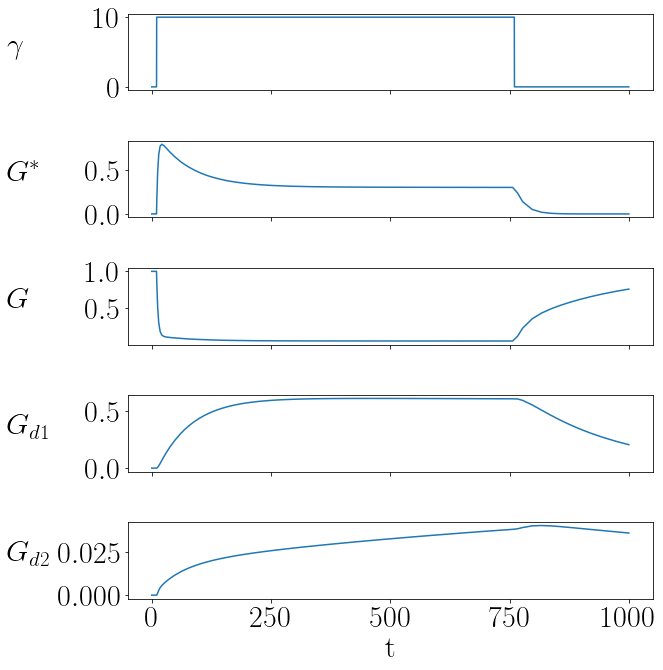

In [5]:
'''
Plot solutions
'''
plt.figure(figsize=(10,20))

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10,10))

#set glutamate plot curve
glut_t, glut = get_input_plot(sol['glutamate_input_type'])

#plot figures
ax[0].plot(glut_t, glut)
ax[1].plot(t, Gstar)
ax[2].plot(t, G)
ax[3].plot(t, Gd1)
ax[4].plot(t, Gd2)

#set xlabel
ax[4].set_xlabel('t')

#set ylabels
ax[0].set_ylabel(r'$\gamma$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

#align ylabels
ax[0].get_yaxis().set_label_coords(-0.23,0.4)
ax[1].get_yaxis().set_label_coords(-0.23,0.4)
ax[2].get_yaxis().set_label_coords(-0.23,0.4)
ax[3].get_yaxis().set_label_coords(-0.23,0.35)
ax[4].get_yaxis().set_label_coords(-0.23,0.35)

fig.tight_layout()

In [58]:
fig.savefig(save + str(1))